# Natural Language Inference with DistilBert

In [1]:
import numpy as np
import pandas as pd
from transformers import DistilBertTokenizer, TFDistilBertModel
import matplotlib.pyplot as plt
import tensorflow as tf
from datasets import load_dataset
from sklearn.model_selection import train_test_split
import gc

2022-12-14 12:32:53.323464: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-12-14 12:32:53.323561: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Distribution Strategy

In [2]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.get_strategy() # for CPU and single GPU
print('Number of replicas:', strategy.num_replicas_in_sync)

2022-12-14 12:33:00.876188: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-12-14 12:33:00.879254: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-12-14 12:33:00.879284: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-14 12:33:00.879305: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (dab5651a59b9): /proc/driver/nvidia/version does not exist
2022-12-14 12:33:00.884072: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

Number of replicas: 8


## Configuration

In [3]:
class CFG:
    batch_size = strategy.num_replicas_in_sync * 16
    sequence_length = 128
    add_external_dataset = True

## Load data

In [4]:
train = pd.read_csv("../input/contradictory-my-dear-watson/train.csv")
train.head()

,id,premise,hypothesis,lang_abv,language,label
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2
2,3931fbe82a,Des petites choses comme celles-là font une di...,J'essayais d'accomplir quelque chose.,fr,French,0
3,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,en,English,0
4,86aaa48b45,ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...,เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร,th,Thai,1


## Load Pretrained model

In [5]:
with strategy.scope():
    tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
    encoder = TFDistilBertModel.from_pretrained("distilbert-base-uncased")
    gc.collect()

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/363M [00:00<?, ?B/s]

2022-12-14 12:33:15.476987: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_layer_norm', 'vocab_transform', 'activation_13', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the 

In [6]:
encoder.summary()

Model: "tf_distil_bert_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
distilbert (TFDistilBertMain multiple                  66362880  
Total params: 66,362,880
Trainable params: 66,362,880
Non-trainable params: 0
_________________________________________________________________


Let's learn about this pretrained model's input and output. When we past a text list to this pretrained model, it returns a dictionary with  key last_hidden_state.

In [7]:
texts = ["hello world.", "how are you doing?"]
text_preprocessed = tokenizer(
    texts, 
    max_length = CFG.sequence_length,
    truncation=True, 
    padding='max_length',
    add_special_tokens=True,
    return_tensors='tf'
)
output = encoder(text_preprocessed)
output

TFBaseModelOutput(last_hidden_state=<tf.Tensor: shape=(2, 128, 768), dtype=float32, numpy=
array([[[-0.13655987, -0.19455986,  0.06066158, ..., -0.15986888,
          0.30029753,  0.38104215],
        [-0.31335416,  0.08432106,  0.544605  , ..., -0.13485642,
          0.7330552 ,  0.47490796],
        [ 0.01543144,  0.08995718,  0.7768145 , ..., -0.04456326,
          0.33837906,  0.2097362 ],
        ...,
        [-0.19495499,  0.2016304 ,  0.6907206 , ..., -0.0099718 ,
          0.17069556,  0.1595645 ],
        [-0.12937163,  0.13508452,  0.4856617 , ..., -0.01744067,
          0.07100686,  0.10527203],
        [-0.18860853, -0.15029155,  0.3208555 , ...,  0.17644355,
          0.01106458,  0.09787782]],

       [[-0.05056328, -0.03165491, -0.01177481, ..., -0.05328209,
          0.3355186 ,  0.23956552],
        [ 0.10443096, -0.16184665, -0.28821132, ..., -0.0870992 ,
          0.2971123 , -0.19777435],
        [ 0.44034845, -0.3077429 ,  0.11389815, ..., -0.7893258 ,
          0.

## Text Preprocessing

In [8]:
def preprocess_data(df):
    df["text"] = "[CLS] " + df["premise"] + " [SEP] " + df["hypothesis"] + " [SEP]"
    return df

In [9]:
%%time
train = preprocess_data(train)
train.head()

CPU times: user 7.55 ms, sys: 4.88 ms, total: 12.4 ms
Wall time: 15 ms


,id,premise,hypothesis,lang_abv,language,label,text
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0,[CLS] and these comments were considered in fo...
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2,[CLS] These are issues that we wrestle with in...
2,3931fbe82a,Des petites choses comme celles-là font une di...,J'essayais d'accomplir quelque chose.,fr,French,0,[CLS] Des petites choses comme celles-là font ...
3,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,en,English,0,[CLS] you know they can't really defend themse...
4,86aaa48b45,ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...,เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร,th,Thai,1,[CLS] ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะ...


## 

## Load MNLI dataset
You can learn more about this dataset [here](https://huggingface.co/datasets/multi_nli).

In [10]:
def load_mnli(use_validation=True):
    result=[]
    dataset=load_dataset('multi_nli')
    print(dataset)
    for record in dataset['train']:
        c1, c2, c3 = record['premise'],record['hypothesis'], record['label']
        if c1 and c2 and c3 in {0, 1, 2}:
            result.append((c1, c2, c3, 'en'))
    result=pd.DataFrame(result, columns=['premise', 'hypothesis', 'label', 'lang_abv'])
    return result

In [11]:
mnli = load_mnli()
mnli.head()

Downloading:   0%|          | 0.00/1.90k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/227M [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset multi_nli downloaded and prepared to /root/.cache/huggingface/datasets/multi_nli/default/0.0.0/591f72eb6263d1ab527561777936b199b714cda156d35716881158a2bd144f39. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['promptID', 'pairID', 'premise', 'premise_binary_parse', 'premise_parse', 'hypothesis', 'hypothesis_binary_parse', 'hypothesis_parse', 'genre', 'label'],
        num_rows: 392702
    })
    validation_matched: Dataset({
        features: ['promptID', 'pairID', 'premise', 'premise_binary_parse', 'premise_parse', 'hypothesis', 'hypothesis_binary_parse', 'hypothesis_parse', 'genre', 'label'],
        num_rows: 9815
    })
    validation_mismatched: Dataset({
        features: ['promptID', 'pairID', 'premise', 'premise_binary_parse', 'premise_parse', 'hypothesis', 'hypothesis_binary_parse', 'hypothesis_parse', 'genre', 'label'],
        num_rows: 9832
    })
})


,premise,hypothesis,label,lang_abv
0,Conceptually cream skimming has two basic dime...,Product and geography are what make cream skim...,1,en
1,you know during the season and i guess at at y...,You lose the things to the following level if ...,0,en
2,One of our number will carry out your instruct...,A member of my team will execute your orders w...,0,en
3,How do you know? All this is their information...,This information belongs to them.,0,en
4,yeah i tell you what though if you go price so...,The tennis shoes have a range of prices.,1,en


In [12]:
mnli = preprocess_data(mnli)
mnli.head()

,premise,hypothesis,label,lang_abv,text
0,Conceptually cream skimming has two basic dime...,Product and geography are what make cream skim...,1,en,[CLS] Conceptually cream skimming has two basi...
1,you know during the season and i guess at at y...,You lose the things to the following level if ...,0,en,[CLS] you know during the season and i guess a...
2,One of our number will carry out your instruct...,A member of my team will execute your orders w...,0,en,[CLS] One of our number will carry out your in...
3,How do you know? All this is their information...,This information belongs to them.,0,en,[CLS] How do you know? All this is their infor...
4,yeah i tell you what though if you go price so...,The tennis shoes have a range of prices.,1,en,[CLS] yeah i tell you what though if you go pr...


## Create TensorFlow dataset

In [13]:
def bert_encode(df, tokenizer):    
    texts = df['text'].tolist()
    tokens = tokenizer(
        texts, 
        max_length = CFG.sequence_length,
        truncation=True, 
        padding='max_length',
        add_special_tokens=True,
        return_tensors='tf'
    )
    if "label" in df.keys():
        tokens["label"] = df["label"]
    return tokens

def preprocess(features):
    input_ids = features.pop("input_ids")
    labels = features.pop("label")
    return input_ids, labels
def make_dataset(df, mode="train"):
    ds = tf.data.Dataset.from_tensor_slices((df))
    if mode == "train":
        ds = ds.shuffle(256)
    ds = ds.batch(CFG.batch_size)
    ds = ds.map(preprocess)
    ds = ds.cache().prefetch(tf.data.AUTOTUNE).repeat()
    return ds

In [14]:
%%time
train_data, valid_data = train_test_split(train, test_size=0.2, random_state=2)
if CFG.add_external_dataset:
    train_data=pd.concat([train_data, mnli.loc[:100000]], axis=0)
    train_data.head()

CPU times: user 32.3 ms, sys: 0 ns, total: 32.3 ms
Wall time: 34 ms


In [15]:
%%time
train_input = bert_encode(train_data, tokenizer)
valid_input = bert_encode(valid_data, tokenizer)
train_ds = make_dataset(train_input)
valid_ds = make_dataset(valid_input, mode="valid")

CPU times: user 1min 34s, sys: 222 ms, total: 1min 34s
Wall time: 1min 34s


Take a look at what training data looks like.

In [16]:
for item in train_ds.take(1):
    print(item)

(<tf.Tensor: shape=(128, 128), dtype=int32, numpy=
array([[  101,   101,  1270, ...,     0,     0,     0],
       [  101,   101,  1339, ...,  1338, 29869,   102],
       [  101,   101,  3100, ...,     0,     0,     0],
       ...,
       [  101,   101,  2027, ...,     0,     0,     0],
       [  101,   101,  2122, ...,     0,     0,     0],
       [  101,   101,  3398, ...,     0,     0,     0]], dtype=int32)>, <tf.Tensor: shape=(128,), dtype=int64, numpy=
array([0, 1, 0, 1, 2, 2, 1, 1, 0, 0, 2, 1, 0, 2, 0, 2, 1, 1, 1, 0, 1, 2,
       0, 0, 2, 0, 0, 1, 2, 2, 0, 2, 1, 1, 2, 0, 0, 2, 2, 0, 2, 0, 1, 2,
       2, 1, 1, 0, 2, 0, 1, 2, 0, 0, 1, 1, 0, 1, 2, 1, 2, 2, 2, 0, 0, 2,
       2, 2, 2, 1, 1, 2, 2, 1, 1, 0, 0, 2, 2, 1, 2, 2, 1, 0, 0, 0, 0, 2,
       1, 0, 1, 1, 1, 2, 2, 0, 1, 1, 0, 0, 2, 2, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 2, 2, 1, 2, 2, 1, 0, 0, 0, 0, 0, 2, 2, 1])>)


## Calcuate class weight

The dataset is relatively balanced. However I would like to add class_weight parameter in keras training method. In this way we often can improve the score a little bit.

<AxesSubplot:>

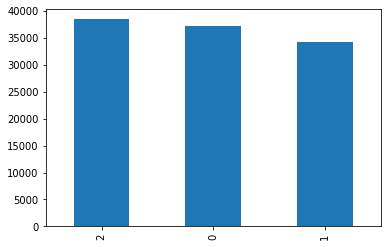

In [17]:
train_data["label"].value_counts().plot(kind="bar")

In [18]:
class_weight = len(train_data["label"]) / train_data["label"].value_counts()
class_weight = dict(class_weight / class_weight.sum())
class_weight

{2: 0.3165196686886762, 0: 0.32727167595322115, 1: 0.3562086553581027}

## Building Model

In [19]:
def build_model():
    inputs = tf.keras.Input(shape=(CFG.sequence_length,), dtype=tf.int32, name="input_ids")
    embedding = encoder(inputs)["last_hidden_state"]
    vector = tf.keras.layers.GlobalAveragePooling1D()(embedding)
    vector = tf.keras.layers.Dropout(0.3)(vector)
    output = tf.keras.layers.Dense(3, activation='softmax')(vector)
      
    model = tf.keras.Model(inputs=inputs, outputs=output)
    model.compile(tf.keras.optimizers.Adam(lr=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])   
    return model 

In [20]:
with strategy.scope():
    model = build_model()
    model.summary() 

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 128)]             0         
_________________________________________________________________
tf_distil_bert_model (TFDist TFBaseModelOutput(last_hi 66362880  
_________________________________________________________________
global_average_pooling1d (Gl (None, 768)               0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 768)               0         
_________________________________________________________________
dense (Dense)                (None, 3)                 2307      
Total params: 66,365,187
Trainable params: 66,365,187
Non-trainable params: 0
_________________________________________________________________


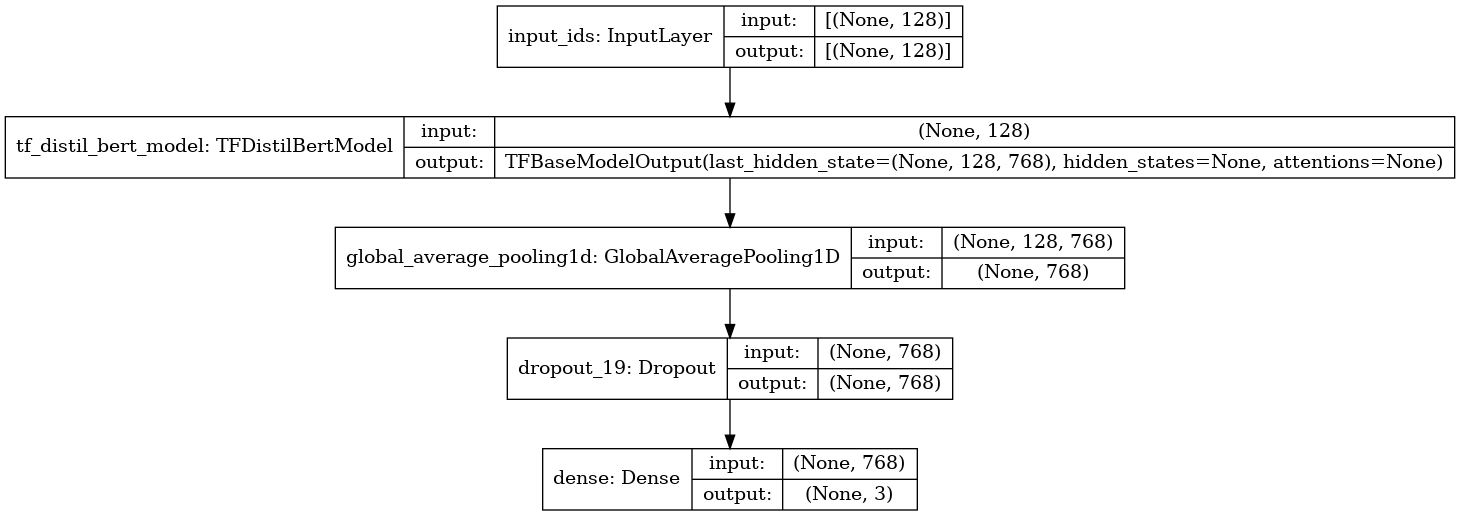

In [21]:
tf.keras.utils.plot_model(model, show_shapes=True)

## Training the model
When I train the model using TPU and and try to save the whole model, error occurs. 

Epoch 1/20
857/857 [==============================] - 86s 56ms/step - loss: 0.3400 - accuracy: 0.4392 - val_loss: 0.9789 - val_accuracy: 0.5647
Epoch 2/20
857/857 [==============================] - 67s 50ms/step - loss: 0.2506 - accuracy: 0.6560 - val_loss: 0.8470 - val_accuracy: 0.5851
Epoch 3/20
857/857 [==============================] - 43s 50ms/step - loss: 0.2209 - accuracy: 0.7038 - val_loss: 0.8392 - val_accuracy: 0.5951
Epoch 4/20
857/857 [==============================] - 43s 50ms/step - loss: 0.1995 - accuracy: 0.7377 - val_loss: 0.8287 - val_accuracy: 0.5990
Epoch 5/20
857/857 [==============================] - 43s 50ms/step - loss: 0.1790 - accuracy: 0.7695 - val_loss: 0.8371 - val_accuracy: 0.6050
Epoch 6/20
857/857 [==============================] - 43s 50ms/step - loss: 0.1612 - accuracy: 0.7941 - val_loss: 0.8640 - val_accuracy: 0.6068
Epoch 7/20
857/857 [==============================] - 43s 50ms/step - loss: 0.1427 - accuracy: 0.8202 - val_loss: 0.9025 - val_accuracy:

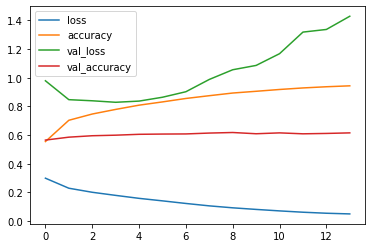

In [22]:
with strategy.scope():
    steps_per_epoch = train_data.shape[0] // CFG.batch_size
    validation_steps = valid_data.shape[0] // CFG.batch_size
    es = tf.keras.callbacks.EarlyStopping(patience=5, monitor="val_accuracy")
    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        "model.h5", 
        monitor="val_accuracy", 
        save_best_only=True, 
        save_weights_only=True, 
        restore_best_weights=True
    )
    history = model.fit(
        train_ds, 
        epochs = 20, 
        steps_per_epoch = steps_per_epoch,
        validation_steps = validation_steps,
        validation_data=valid_ds,
        class_weight=class_weight,
        callbacks=[es, checkpoint]
    )
    pd.DataFrame(history.history).plot()

## Create Submission file

In [23]:
test = pd.read_csv("../input/contradictory-my-dear-watson/test.csv")
test = preprocess_data(test)
test_input = bert_encode(test, tokenizer)
test_ds = tf.data.Dataset.from_tensor_slices((test_input["input_ids"])).batch(CFG.batch_size)
predictions = np.argmax(model.predict(test_ds), axis=1)
submission = test.id.copy().to_frame()
submission['prediction'] = predictions
submission.to_csv("submission.csv", index = False)
submission.head()

,id,prediction
0,c6d58c3f69,2
1,cefcc82292,1
2,e98005252c,0
3,58518c10ba,1
4,c32b0d16df,0
